In this notebook we will implement a quantum machine learning model that will learn the Sine function regression task.

# Import libraries

Our libraries will consist of Jax and Optax as well as the usual Pennylane, so that the processing, especially in the training stage will be faster and efficient.

Jax & Optax are modules that integrate well with Pennylane, and can speed up and increase the quality of model train and assesment.

In [1]:
import pennylane as qml
import jax
import optax
from pennylane import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt

# Initialise data

We want to simulate the sine function, so we'll simply use `numpy.sin`. To make our model have the ability to generalise over any data, not just exact similar sine points, we added some noise to the data; to spice things up:

In [2]:
def generate_data_points(num_points, std, seed):  # number of points, standard deviation (for the noise), random seed (for reproducability)
    np.random.seed(seed)
    X = np.linspace(0, 2 * np.pi, num_points)  # our period of (0, 2pi)
    Y = np.sin(X)  # our data points on the sine function
    noise = np.random.normal(0, std, Y.shape)  # here we introduce some noise to our data based on the std
    Y_noisy = Y + noise  # and now we add the noise to the original data
    return X, Y_noisy

We create 2 train and test datasets, with their respective X and Y. Notice we changed the seed of train and test so for it to not be similar data:

In [3]:
X_train_data, Y_train_data = generate_data_points(num_points=100, std=0.1, seed=17)
X_test_data, Y_test_data = generate_data_points(num_points=50, std=0.1, seed=106)

Here we can see the training set created, compared to the actual sine function line:

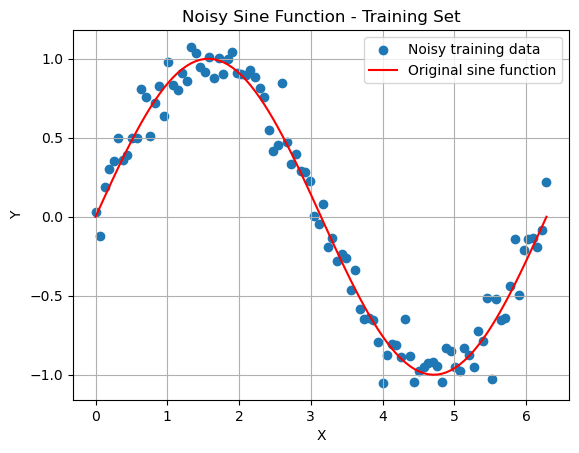

In [4]:
plt.scatter(X_train_data, Y_train_data, label='Noisy training data')
plt.plot(X_train_data, np.sin(X_train_data), label='Original sine function', color='red')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Sine Function - Training Set')
plt.grid()
plt.show()

And here we see the test set compared to the sine function line:

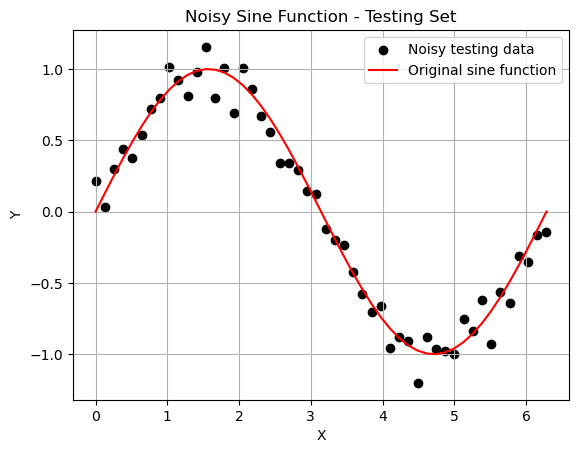

In [5]:
plt.scatter(X_test_data, Y_test_data, label='Noisy testing data', color='black')
plt.plot(X_test_data, np.sin(X_test_data), label='Original sine function', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Sine Function - Testing Set')
plt.grid()
plt.show()

# Quantum Machine Learning Model

This section is made of the following steps, in order:

- Initiating the quantum device
- Implementing our QML model ansatz
- Defining our full QML model
- Defining the loss/cost function

## Initialise the device

We'll use the usual 'default.qubit' device with 4 wires to implement a more complex model:

In [6]:
dev = qml.device('default.qubit', wires=4)

## QML Ansatz

The ansatz is the core part of QML models. It is a series of quantum gates on a quantum circuit that process the data.

There are 2 main sections of our quantum circuit: the data embedding/encoding, and the ansatz gates.

Here we implement our quantum circuit as a qnode, which consists of 
- an angle embedding layer to encode the input data to angles so the proceeding gates can apply calculations on them, 
- and our main ansatz which are strongly entangling layers; opening those layers reveals rotation gates applied on each qubit, and then entangling them with CNOT gates. 

Here we have used some usual and default values such as linear entanglement:

In [7]:
@qml.qnode(dev)
def circuit(weights, data):
    qml.AngleEmbedding(data, wires=range(4), rotation='X')  # encoding the data via X rotation gates into angles
    qml.StronglyEntanglingLayers(weights=weights, wires=range(4))  # our ansatz consisting of rotation and CNOT gates; this will apply based on the number of our layers
    return qml.expval(qml.PauliZ(wires=0))  # measuring our expected value on the Z axis which will be our model's prediction

Here you can see the plot of our circuit:

(<Figure size 500x500 with 1 Axes>, <Axes: >)

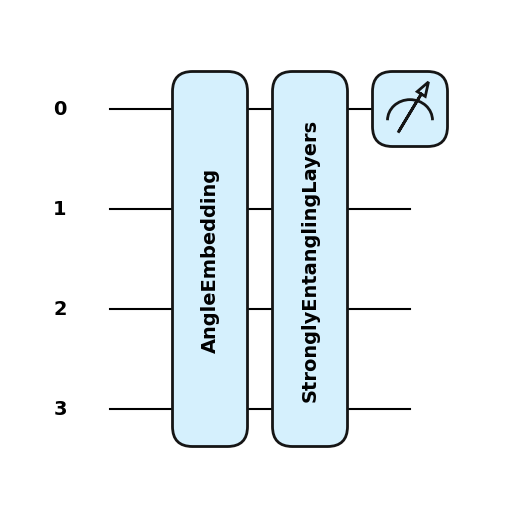

In [8]:
qml.draw_mpl(circuit, style='pennylane')([[[0,0,0], [0,0,0], [0,0,0], [0,0,0]]], [0,0,0,0])

## Full Model

The term "Full Model" doesn't really mean anything significant for now. The implementation is quite simple, as one only adds a bias term to the circuit defined above to introduce variationality.

Although we have also added a padding to the data to ensure our data has the correct size and shape before feeding it to our circuit/model:

In [9]:
def sine_model(data, weights, bias):
    data_padded = jnp.pad(data, (0, max(0, 4 - data.shape[0])), mode='constant')
    return circuit(weights, data_padded) + bias

## Loss/Cost Function

The terms "loss function" and "cost function" are interchangeably used in ML; although it's important to note one difference between them: loss function is the difference of the predicted data value of the model and the actual data value of a *single* point, whereas cost function is the loss function applied onto the entire dataset.

Here we defined our loss function as a `jax.jit` function. JIT (Just-In-Time) is a kind of compilation technique that first compiles the code in its first iteration, then applies that compilation to the rest of the iterations. In this way, the first iteration may take a while to complete, but then the rest of the iterations finish exceptionally fast.

We have used the common MSE (Mean Squared Error) as our loss metric:

In [10]:
@jax.jit
def loss_func(params, data, targets):
    data = jnp.expand_dims(data, axis=1)  # ensure data has correct shape
    preds = jax.vmap(lambda x: sine_model(x, params['weights'], params['bias']))(data)  # vmap creates a function that maps our sine model over the data arguments
    return jnp.mean((preds - targets) ** 2)  # our MSE metric which applied to datapoints creates our loss function

# Training the QML Model

We reach an exciting part of training and evaluating (based on loss) our model.

- Initialise weights, bias, and number of layers
- Initialise our optimiser and update sequence
- Start training loop

## Initial values

We have to give our model some initial parameters so then the optimiser can find the best value of them.

We have 2 kinds of initial values:
- Hyperparameters which are defined and changed by the programmer and the optimiser doesn't change them
- Parameters which are initially defined by the programmer, but the optimiser tries to find the optimum value and can change them

Here we define our hyperparameter, number of layers, to 3.

And define our parameters, weights and bias, to a matrix array of 1s and 0.15 respectively.

Note that these values were chosen randomly just so that the optimiser can later on change these to the optimum values.

In [11]:
layers = 3
w = jnp.ones([layers, 4, 3])  # weights; corrected shape to [layers, num_wires, 3]
b = jnp.array(0.15)  # bias; single array of [0.15]
params = {'weights': w, 'bias': b}  # our parameters dict

## Optimiser and Update Sequence

In this section we define our optimiser and the update sequence for the optimiser to find the optimal parameter values.

Our optimiser will be from Optax, which is a Jax-compatible module with many options of optimisers.

The reason for using Optax is for it to efficiently apply the JIT technique on our JIT functions.

The selected optimiser is Adam (because it combines two optimisation techniques of Gradient Descent and Adagrad for better results) will a learning rate of 0.25.

The update sequence can be seen as follows:

In [12]:
opt = optax.adam(learning_rate=0.25)  # our optimiser

@jax.jit  # our update sequence which will also be JIT function to run faster
def update(params, opt_state, data, targets):
    loss_val, grads = jax.value_and_grad(loss_func)(params, data, targets)  # first Jax calculates the parameter values and their gradients
    updates, opt_state = opt.update(grads, opt_state)  # the gradients from the previous step will be fed into our optimiser, and it returns the updated states of the params
    params = optax.apply_updates(params, updates)  # and finally we apply the updates on the parameters with optax
    return params, opt_state, loss_val

## Training

The training loop will simply apply the update sequence based on the number of epochs (iterations). We will also print the loss every 5 epoch to see how the model is doing. The lower the loss, the better the model.

In [13]:
def train(params, data, targets, num_epochs=60):  # loop for 60 iterations as default
    opt_state = opt.init(params)  # initiate the optimiser on the params
    for epoch in range(num_epochs):
        params, opt_state, loss_val = update(params, opt_state, data, targets)  # apply update sequence
        if epoch % 5 == 0:
            print(f"Epoch {epoch} - Loss: {loss_val:.6f}")  # print current state of the model
    return params

And now we apply the training to the parameters to get the optimised values:

In [14]:
params = train(params, X_train_data, Y_train_data)

Epoch 0 - Loss: 0.468813
Epoch 5 - Loss: 0.038375
Epoch 10 - Loss: 0.030094
Epoch 15 - Loss: 0.017520
Epoch 20 - Loss: 0.016190
Epoch 25 - Loss: 0.013536
Epoch 30 - Loss: 0.012542
Epoch 35 - Loss: 0.012596
Epoch 40 - Loss: 0.012534
Epoch 45 - Loss: 0.012521
Epoch 50 - Loss: 0.012439
Epoch 55 - Loss: 0.012450


# Testing the Model

And at last, we test our QML model on the test dataset, and plot the results to see if it learned the sine function pattern.

The model gives predictions of where the test datapoints could be, based on it's learning:

In [15]:
test_preds = jax.vmap(lambda x: sine_model(x, params['weights'], params['bias']))(jnp.expand_dims(X_test_data, axis=1))  # vmap to map the sine model to the data

Let's plot the data to see how our model did!

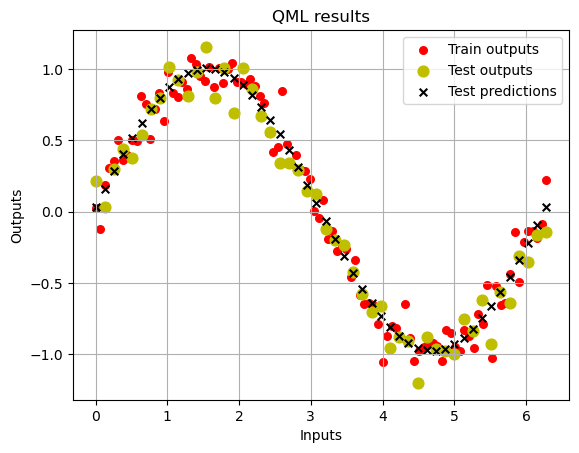

In [17]:
plt.scatter(X_train_data, Y_train_data, s=30, c='r', marker="o", label='Train outputs')
plt.scatter(X_test_data, Y_test_data, s=60, c='y', marker="o", label='Test outputs')
plt.scatter(X_test_data, test_preds, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")
plt.legend(loc='upper right')
plt.grid()
plt.show()

As we can see, our model has learned the sine function pretty well despite the noise we introduced! This shows that our model can generalise pretty good!

# Summary

In this notebook we saw how to implement a more complex QML model to learn the sine function. We saw that more complex models can generalise better on noisy data.

In short there are these main steps to a QML model:
- Defining circuit: Encoding input data based on different embeddings (here, angle embedding), and Implementing a quantum ansatz (a series of gates)
- Defining the full model: Usually done by adding a bias term to the circuit
- Defining loss metric and function
- Training: Optimising initial parameters with optimiser
- Testing: Checking out how the model works on unseen and new data